# Geodesic Sinkhorn 

Codebase inspired by: https://github.com/KrishnaswamyLab/GeoSinkhorn

In [1]:
import numpy as np 
import pandas as pd 
import warnings
import matplotlib.pyplot as plt
import cv2
import random
from sklearn.neighbors import kneighbors_graph

from scipy.sparse.linalg import eigsh
from scipy.special import ive

## Matrix exponential approximation & Laplacian computing

In [2]:
def compute_chebyshev_coefficients(eigval: np.ndarray, t: float, K: int):
    """
    Compute Chebyshev coefficients using PyTorch.
    
    Parameters:
        eigval (torch.Tensor): Eigenvalues as a PyTorch tensor.
        t (float): Scaling parameter.
        K (int): Number of terms in the expansion.

    Returns:
        torch.Tensor: Computed Chebyshev coefficients.
    """
    
    coefficients = 2.0 * ive(np.arange(0, K + 1), -t * eigval)
    return coefficients



def chebyshev_matrix(
    L: np.ndarray,
    coeff: np.ndarray,

) -> np.ndarray:
    """
    Perform matrix exponential multiplication using Chebyshev polynomial approximation.
    
    Parameters:
        L (np.ndarray): Matrix for the operation.
        X (np.ndarray): Input vector or matrix.
        coeff (np.ndarray): Chebyshev coefficients.
        eigval (np.ndarray): Eigenvalues of the matrix.
    
    Returns:
        np.ndarray: Result of the matrix exponential multiplication.
    """
    

    # Initialize terms
    In = np.eye(len(L))
    B = coeff[0] / 2 * In

    # Iterate through remaining coefficients
    Ti, Tiprev = L - In, In
    for i in range(1, len(coeff)):
        B += coeff[i] * Ti
        Ti, Tiprev = 2 * (L - In) @ Ti + Tiprev, Ti

    return B

In [3]:
def normalize_symmetric_laplacian(A: np.ndarray) -> np.ndarray:
    """
    Compute the normalized symmetric Laplacian from an adjacency matrix.

    Parameters:
        A (np.ndarray): Affinity matrix.

    Returns:
        np.ndarray: Normalized symmetric Laplacian matrix.
    """
    D = A.sum(axis=1)
    inv_sqrt_D = np.diag(1.0 / np.sqrt(D))
    identity = np.eye(A.shape[0])
    return identity - inv_sqrt_D @ A @ inv_sqrt_D


def laplacian_from_data(data: np.ndarray, kneighbors: int, sigma: float) -> np.ndarray:
    """
    Compute the normalized Laplacian from data using a Gaussian kernel.

    Parameters:
        data (np.ndarray): Data points.
        sigma (float): Kernel width.
        alpha (int): Exponent for the Gaussian kernel.

    Returns:
        np.ndarray: Normalized Laplacian matrix.
    """
    affinity = np.exp(
        -(
            (
                kneighbors_graph(
                    data, n_neighbors=kneighbors, mode="distance"
                ).toarray()
                / (2 * sigma)
            )
            ** 2
        )
    )
    return normalize_symmetric_laplacian(affinity)


class HeatFilter:
    """
    Heat kernel filter for graph diffusion.

    """

    def __init__(
        self,
        tau: float,  # Diffusion time
        order: int,  # Polynomial degree or approximation steps
        laplacian: np.ndarray,  # Laplacian matrix
    ) -> None:
        self.tau = tau
        self.order = order

        self.laplacian = laplacian

        # Compute eigenvalue-based scaling and Chebyshev coefficients
        max_eigval = eigsh(self.laplacian, k=1, return_eigenvectors=False)[0] / 2
        self.phi = max_eigval
        self.chebyshev_coeffs = compute_chebyshev_coefficients(
            self.phi, self.tau, self.order
        )
        self.chebyshev_mat = chebyshev_matrix(self.laplacian, self.chebyshev_coeffs)

## Geodesic Sinkhorn algorithm

In [4]:
class GeoSinkhorn:
    """
    A class implementing the GeoSinkhorn algorithm for transport with heat kernel filtering.
    """

    def __init__(self, tau: float, order: int, laplacian):
        """
        Initialize the GeoSinkhorn instance.

        Parameters:
            tau (float): Diffusion time parameter for the heat kernel.
            order (int): Approximation order for the heat filter.
            laplacian: Laplacian matrix .
        """
        
        self.tau = tau
        self.heat_filter = HeatFilter(
            tau=tau, order=order, laplacian=laplacian
        ).chebyshev_mat

    def __call__(
        self,
        m_0: np.ndarray,
        m_1: np.ndarray,
        tol: float = 1e-4,
        max_iter: int = 1000,
    ) -> float:
        """
        Perform the GeoSinkhorn iterative process.

        Parameters:
            m_0 (np.ndarray): Input distribution (source).
            m_1 (np.ndarray): Input distribution (target).
            tol (float): Stopping threshold for convergence.
            max_iter (int): Maximum number of iterations.

        Returns:
            float: The final KL divergence.
            np.ndarray, np.ndarray: Dual variables `u` and `v`.
        """
        eps = 1e-8

        if m_0.shape != m_1.shape:
            raise ValueError("`m_0` and `m_1` must have the same shape.")
        
        self.N = m_0.shape[0]
        # initialize iterate vectors
        u, v = np.ones(self.N), np.ones(self.N)

        for i in range(1, max_iter + 1):
            u_prev, v_prev = u, v
            
            u = m_0 / (self.heat_filter @ v)
            v = m_1 / (self.heat_filter @ u)

            # Check for numerical instability
            if np.any(np.isnan(u)) or np.any(np.isnan(v)) or np.any(np.isinf(u)) or np.any(np.isinf(v)):
                warnings.warn("Either NaN or inf were found in the distributions")
                u, v = u_prev, v_prev
                break

            delta_v = np.sum(np.abs(v - v_prev))
            if delta_v < tol:
                print(f"Converged at iteration {i}.")
                break

        return u, v

## Sinkhorn algorithm

In [5]:
class Sinkhorn:
    """
    A class implementing the Sinkhorn algorithm.
    """

    def __init__(self, tau: float):
        """
        Initialize the Sinkhorn instance.

        Parameters:
            tau (float): Diffusion time parameter for the heat kernel.
            order (int): Approximation order for the heat filter.
            laplacian: Laplacian matrix .
        """
        
        self.tau = tau

    def gaussian_kernel(self, x1, x2, gamma=1.0):
        """
        Compute the RBF kernel matrix between two 2D arrays.
        """
        sq_distances = []
        for i in range(len(x1)):
            sq_distances.append([])
            for j in range(len(x2)):
                sq_distances[-1].append((x1[i, 0] - x2[j,0])**2 + (x1[i, 1] - x2[j, 1])**2)
        sq_distances = np.array(sq_distances)
        return np.exp(sq_distances / self.tau)

    def __call__(
        self,
        m_0: np.ndarray,
        m_1: np.ndarray,
        x_0: np.ndarray,
        x_1: np.ndarray,
        max_iter: int = 1000,
    ) -> float:
        """
        Perform the Sinkhorn iterative process.

        Parameters:
            m_0 (np.ndarray): Input distribution (source).
            m_1 (np.ndarray): Input distribution (target).
            tol (float): Stopping threshold for convergence.
            max_iter (int): Maximum number of iterations.

        Returns:
            float: The final KL divergence.
            np.ndarray, np.ndarray: Dual variables `u` and `v`.
        """
        
        self.N = m_0.shape[0]
        self.M = m_1.shape[0]
        
        # initialize iterate vectors
        u, v = np.ones(self.N), np.ones(self.M)
        self.K = self.gaussian_kernel(x_0, x_1)
        for i in range(1, max_iter + 1):
            u_prev, v_prev = u, v
            u = m_0 / (self.K @ v)
            v = m_1 / (np.transpose(self.K) @ u)

            # Check for numerical instability
            if np.any(np.isnan(u)) or np.any(np.isnan(v)) or np.any(np.isinf(u)) or np.any(np.isinf(v)):
                warnings.warn("Either NaN or inf were found in the distributions")
                u, v = u_prev, v_prev
                break

        return u, v

## Generate point distributions

In [6]:
def get_random_points_on_black(image, num_points):
    """
    Get randomly distributed points on the black areas of an RGB image.

    Parameters:
        image (np.ndarray): Input RGB image (H, W, 3).
        num_points (int): Number of random points to sample.

    Returns:
        np.ndarray: Array of shape (num_points, 2) with randomly sampled points.
    """
    grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Create a mask for black pixels (assuming black is [0, 0, 0])
    # Adjust the threshold if necessary for nearly-black pixels
    black_mask = grayscale == 0

    # Get the coordinates of black pixels
    black_coords = np.argwhere(black_mask)  # Returns (row, col) pairs

    if len(black_coords) == 0:
        raise ValueError("No black pixels found in the image.")

    # Randomly sample points from the black pixel coordinates
    sampled_indices = random.sample(range(len(black_coords)), min(num_points, len(black_coords)))
    random_points = black_coords[sampled_indices]

    return random_points


## Image loading : moon crescent

In [7]:
from gen_geometry import draw_horned_ball

points, _, _ = draw_horned_ball(1000)

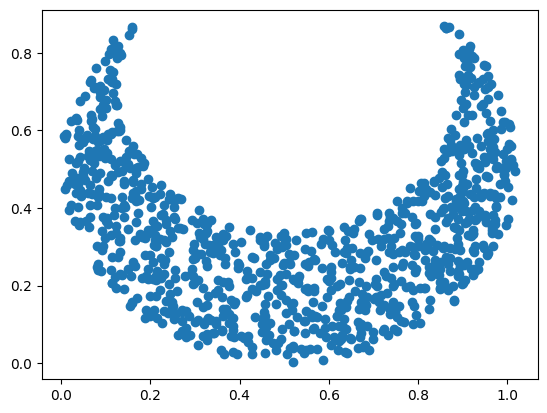

In [8]:
_, ax = plt.subplots()
ax.scatter(points[:,0], points[:,1])

In [9]:
center_a, r_a = [0.1, 0.8], 0.4
center_b, r_b = [0.9, 0.8], 0.4
# center_a, r_a = [0.1, 0.8], 0.3
# center_b, r_b = [0.3, 0.2], 0.1
a = points[np.sqrt((points[:,0] - center_a[0])**2 + (points[:,1] - center_a[1])**2) < r_a, :]
b = points[np.sqrt((points[:,0] - center_b[0])**2 + (points[:,1] - center_b[1])**2) < r_b, :]

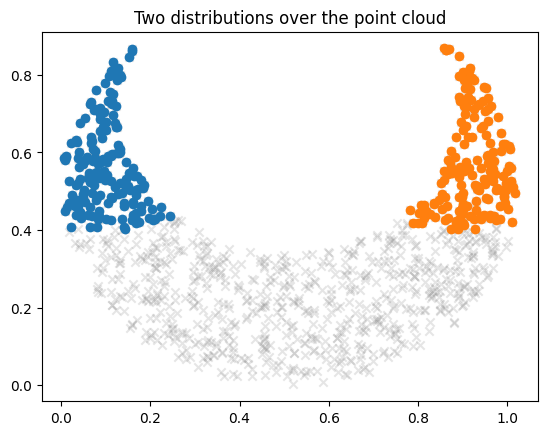

In [10]:
_, ax = plt.subplots()
ax.set_title("Two distributions over the point cloud")
ax.scatter(points[:,0], points[:,1], alpha=0.2, marker="x", color="gray")
ax.scatter(a[:,0], a[:,1])
ax.scatter(b[:,0], b[:,1])

In [11]:
sinkhorn = Sinkhorn(tau=1)
u, v = sinkhorn(np.ones((len(a),)), np.ones((len(b),)), a, b, max_iter=50)

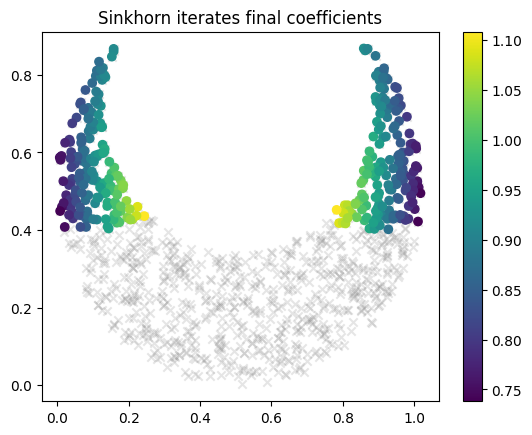

In [12]:
fig, ax = plt.subplots()
ax.scatter(points[:,0], points[:,1], alpha=0.2, marker="x", color="gray")
ax.scatter(a[:,0], a[:,1], c=np.log(u))

s = ax.scatter(b[:,0], b[:,1], c=np.log(v))
ax.set_title("Sinkhorn iterates final coefficients")
plt.colorbar(s)
plt.savefig("../results/euclidean_moon.png")

In [13]:
# This function is useful as we need distributions that are the same length as the one used for the Laplacian.

def create_mask_from_subarray(big_array, subarray):
    """
    Generate a mask where the value equals 1 if the row of an array is present in a subarray.

    Parameters:
        big_array (np.ndarray): Array on which we mask value.
        subarray  (np.ndarray): Subarray to create the mask.

    Returns:
        np.ndarray: Array of shape big_array with 1 if value is in subarray 0 otherwise.
    """

    # Initialize the mask with zeros

    mask = np.zeros(len(big_array), dtype=int)

    # Iterate over rows in the subarray

    for row in subarray:

        # Find rows in the big_array matching the current subarray row

        matches = np.all(big_array == row, axis=1)

        mask[matches] = 1


    return mask

In [14]:
# Generate data and build graph.

lap = laplacian_from_data(points, kneighbors=350, sigma=1.0)

# Instantiate the Geodesic Sinkhorn class
geo_sinkhorn = GeoSinkhorn(tau=0.01, order=5, laplacian=lap)

# Compute the distance between the two signals
u1, v1 = geo_sinkhorn(create_mask_from_subarray(points, a), create_mask_from_subarray(points, b), max_iter=20)


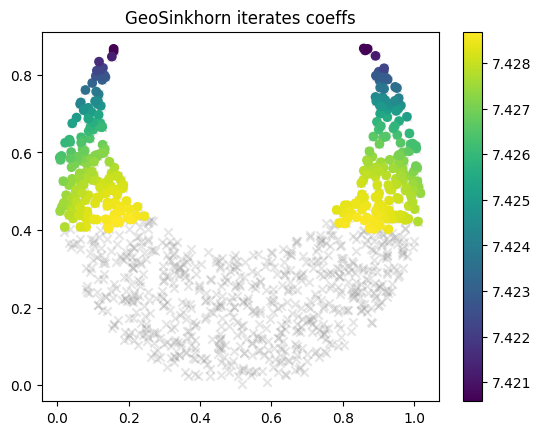

In [15]:
_, ax = plt.subplots()
ax.scatter(points[:, 0], points[:, 1], alpha=0.2, marker="x", color="gray")
mask_a = (create_mask_from_subarray(points, a)[:, np.newaxis] * points)[u1 != 0]
ax.scatter(
    mask_a[:, 0],
    mask_a[:, 1],
    c=np.log(u1[u1 != 0]) / np.linalg.norm(np.log(u1[u1 != 0])),
)
mask_b = (create_mask_from_subarray(points, b)[:, np.newaxis] * points)[v1 != 0]
s = ax.scatter(mask_b[:, 0], mask_b[:, 1], c=np.log(v1[v1 != 0]))
ax.set_title("GeoSinkhorn iterates coeffs")
plt.colorbar(s)
plt.savefig("../results/geodesic_moon.png")

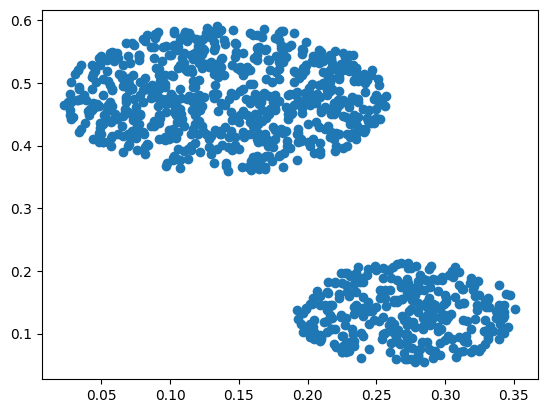

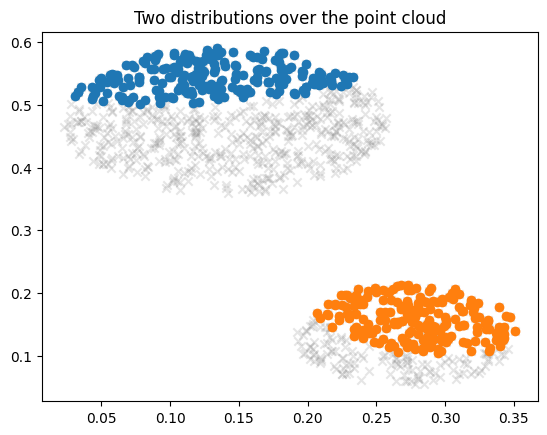

In [16]:
## Image loading : moon crescent
from gen_geometry import draw_horned_ball

points, _, _ = draw_horned_ball(1000, "./img/two circles.png")
_, ax = plt.subplots()
ax.scatter(points[:,0], points[:,1])

center_a, r_a = [0.1, 0.8], 0.3
center_b, r_b = [0.3, 0.2], 0.1
a = points[np.sqrt((points[:,0] - center_a[0])**2 + (points[:,1] - center_a[1])**2) < r_a, :]
b = points[np.sqrt((points[:,0] - center_b[0])**2 + (points[:,1] - center_b[1])**2) < r_b, :]
_, ax = plt.subplots()
ax.set_title("Two distributions over the point cloud")
ax.scatter(points[:,0], points[:,1], alpha=0.2, marker="x", color="gray")
ax.scatter(a[:,0], a[:,1])
ax.scatter(b[:,0], b[:,1])

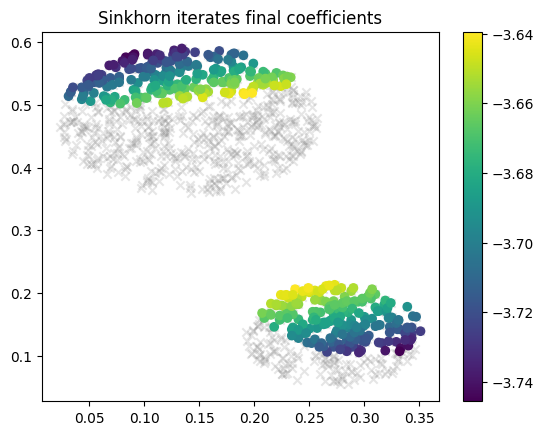

In [17]:
sinkhorn = Sinkhorn(tau=1)
u, v = sinkhorn(np.ones((len(a),)), np.ones((len(b),)), a, b, max_iter=50)
fig, ax = plt.subplots()
ax.scatter(points[:,0], points[:,1], alpha=0.2, marker="x", color="gray")
ax.scatter(a[:,0], a[:,1], c=np.log(u))

s = ax.scatter(b[:,0], b[:,1], c=np.log(v))
ax.set_title("Sinkhorn iterates final coefficients")
plt.colorbar(s)
plt.savefig("../results/euclidean_circles.png")

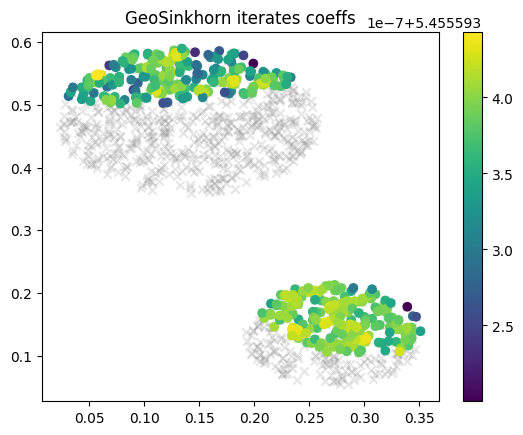

In [18]:
lap = laplacian_from_data(points, kneighbors=6, sigma=1.0)

# Instantiate the Geodesic Sinkhorn class
geo_sinkhorn = GeoSinkhorn(tau=0.01, order=5, laplacian=lap)

# Compute the distance between the two signals
u1, v1 = geo_sinkhorn(create_mask_from_subarray(points, a), create_mask_from_subarray(points, b), max_iter=20)

_, ax = plt.subplots()
ax.scatter(points[:, 0], points[:, 1], alpha=0.2, marker="x", color="gray")
mask_a = (create_mask_from_subarray(points, a)[:, np.newaxis] * points)[u1 != 0]
ax.scatter(
    mask_a[:, 0],
    mask_a[:, 1],
    c=np.log(u1[u1 != 0]) / np.linalg.norm(np.log(u1[u1 != 0])),
)
mask_b = (create_mask_from_subarray(points, b)[:, np.newaxis] * points)[v1 != 0]
s = ax.scatter(mask_b[:, 0], mask_b[:, 1], c=np.log(v1[v1 != 0]))
ax.set_title("GeoSinkhorn iterates coeffs")
plt.colorbar(s)
plt.savefig("../results/geodesic_circles.png")